In [ ]:
from IPython.display import display, HTML

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from preprocess_utils import preprocess_texts
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from bert_embeddings import load_bert_embeddings
from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
import config as CONFIG

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


Notes:
-------
* Reasons a document may not get a context word when sampling
    * IDF thresh
    * Unkown (missing from vocabulary)
    * when tokenized all are word pieces (if not observing word pieces)
    * Contains only stopwords and numbers

Still Working On :
-------------------
* Flip labels for heterogeneous - **done**
* Replace tokens for pos samples - **done**
* Batch size > 2
* Iterative training
* cross val for parameter choosing
* split train for val set 
* freeze bert layer 12 option

Flow :
------

* Dataset Prep
    * Preprocess
    * context word generation
* Bert Embeddings For Clustering
* Clustering
* Picking Cluster Pairs
* For each Cluster Pair :
    * Training
    * Metric Calculation

In [4]:
data_path = "../sampled_articles_from_relevant_data.csv"

In [75]:
test_b = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

In [81]:
for name, param in test_b.named_parameters():
    print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [5]:
# data_utils

# Need:
# 1) A way to generate vocabulary to sample from
# 2) Sampling Context Words
# 3) Negative Binary Sampling to generate negative labels for the context words

def load_data(file_path):
    """
    """
    tokenizer = load_tokenizer()
    df = pd.read_csv(data_path)
    df.drop(columns=["all_text"],inplace=True)
    df["processed_title"] = preprocess_texts(df["title"].tolist())
    return df
    

def calc_idf(vocab_dict,num_docs = 100000):
    """
    idf_t = log(N/df_t)
    
    Large it is rarer the term, smaller it is more frequent the term
    """
    return {key: np.log2(num_docs/vocab_dict[key]) for key in vocab_dict.keys()}

def filter_vocab(vocab_idf_dict,thresh=10.0,filter_word_pieces=True):
    """
    """
    # remove words from title vocab that have very low idf values and are stopwords
    stop_words = set(stopwords.words("english"))
    vocab_idf = dict(filter(lambda x: x[1]>=thresh, vocab_idf_dict.items()))
    vocab_idf = dict(filter(lambda x: x[0] not in stop_words, vocab_idf.items()))
    vocab_idf = dict(filter(lambda x: "UNK" not in x[0], vocab_idf.items())) # Token absent from bert's vocab
    vocab_idf = dict(filter(lambda x: not x[0].isnumeric(), vocab_idf.items())) # Don't include numbers to represent context words
    vocab_idf = dict(filter(lambda x: len(x[0]) >= 3,vocab_idf.items())) # filter out small words
    
    if filter_word_pieces:
        vocab_idf = dict(filter(lambda x: "##" not in x[0], vocab_idf.items()))
    
    
    
    return vocab_idf

def get_vocab(text_list):
    """
    Here we get the vocab to sample from for obtaining our context word also has idf information
    
    Strategy 1: Using words from the title
    """
    tokens_list = []
    tokenizer = load_tokenizer()
    vocab_df = defaultdict(int)
    for text in text_list:
        token_ids = tokenizer.encode(text,add_special_tokens=False)
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        
        for token in tokens:
            vocab_df[token] +=1
        
    vocab_idf = calc_idf(vocab_df)
    
    print("Vocab_size : %s" %str(len(vocab_idf.keys())))
    
    return vocab_idf

def replace_context_word(token_text,context_word):
    """
    """
    token_text.remove(context_word)
    
    return token_text

def sample_context_words(text_list,idf_thresh=10.0,pos_sample_num=3,neg_sample_num=3,cword_type="pos",filter_word_pieces=True):
    """
    """
    vocab_idf = get_vocab(text_list)
    vocab_idf = filter_vocab(vocab_idf,
                             thresh=idf_thresh,
                             filter_word_pieces=filter_word_pieces)
    
    print("Vocab Size After Filtering : %s" %str(len(vocab_idf.keys())))
    tokenizer = load_tokenizer()
    
    if cword_type == "pos":
        
        context_words = []
        fails = 0
        for text in text_list :
            context_word = sample_context_words_pos(text,vocab_idf,tokenizer,filter_word_pieces=filter_word_pieces,pos_sample_num=pos_sample_num)
            if "DROP_THIS" in Counter(context_word) and Counter(context_word)["DROP_THIS"] == pos_sample_num:
                fails+=1
            context_words.append(context_word)
        
        print("Failed to find context words for : %s docs" %str(fails))
        return context_words
    
    else:
        
        context_words = []
        fails= 0
        for text in text_list :
            # result is list of lists where list[0] has length = neg_sample_num
            con_wl = sample_context_words_neg(text,vocab_idf,tokenizer,neg_sample_num=neg_sample_num)
            if con_wl == None:
                fails+=1
            context_words.append(con_wl)
            
        print("Failed to find context words for : %s docs" %str(fails))
        return context_words

def sample_context_words_pos(text,vocab_idf,tokenizer,pos_sample_num=3,filter_word_pieces=True):
    """
    Sample from titles vocab but don't include stopwords or low-idf terms (frequent terms)
    """
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text,add_special_tokens=False))
    
    if filter_word_pieces:
        tokens = [t for t in tokens if "#" not in t]
    
    sampled_indices = random.sample(range(len(tokens)),k=len(tokens))
    context_word = None
    loop_counter = 0
    temp_c = 0
    context_words = []
    for indice in sampled_indices:
        if temp_c == pos_sample_num:
            break
        context_word = tokens[sampled_indices[indice]]
        if context_word in vocab_idf:
            context_words.append(context_word)
            context_word = None
            temp_c +=1
            
    # Nones to add:
    nones_to_add = pos_sample_num - len(context_words)
    if nones_to_add > 0:
        context_words += ["DROP_THIS"] * nones_to_add
    
    return context_words


def sample_context_words_neg(text,vocab_idf,tokenizer,neg_sample_num=3):
    """
    Similar to Pos context word sampling 
    
    sample from titles vocab but don't include stopwords or low-idf terms (frequent terms) and not in text
    """
    
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text,add_special_tokens=False))
    
    context_words = None
    hard_stop = 0
    while True:
        context_words = random.sample(list(vocab_idf.keys()),k=neg_sample_num)
        hard_stop += 1
        not_in_vocab = 0
        for c_w in context_words:
            if c_w not in tokens:
                not_in_vocab +=1
        
        if not_in_vocab == neg_sample_num:
            break
        
        if hard_stop == 11:
            context_words = None
            break
    
    return context_words

In [41]:
def batch_text_gen(input_1_list,
                   input_2_list,
                   output_1_list,
                   output_2_list,batch_size=500):
    """
    """
    for ndx in range(0,len(input_1_list),batch_size):
        yield input_1_list[ndx:min(ndx+batch_size,len(input_1_list))], input_2_list[ndx:min(ndx+batch_size,len(input_2_list))], output_1_list[ndx:min(ndx+batch_size,len(output_1_list))], output_2_list[ndx:min(ndx+batch_size,len(output_2_list))]

def tokenize_4bert_batch(input1,input2,output1,output2,tokenizer):
    """
    """
    cuda1 = torch.device('cuda:1')
    tokenized_tensor = torch.LongTensor([tokenizer.encode(text,
                                                          truncation=True,
                                                          padding="max_length",
                                                          max_length=500, 
                                                          add_special_tokens=True)
                                                          for text in input1])
    
    tokenized_context_word = torch.LongTensor([tokenizer.encode(word,truncation=True,add_special_tokens=False,max_length=1) for word in input2])
    
    class_labels = torch.FloatTensor(output1)
    word_labels = torch.FloatTensor(output2)
    
    tokenized_tensor = tokenized_tensor.to(cuda1)
    tokenized_context_word = tokenized_context_word.to(cuda1)
    class_labels = class_labels.to(cuda1)
    word_labels = word_labels.to(cuda1)
    
    return tokenized_tensor, tokenized_context_word, class_labels, word_labels


# Model

class AttentionMT(nn.Module):
    
    def __init__(self,embedding_size=768,verbose=True,bert_train=False):
        super(AttentionMT,self).__init__()
        
        cuda1 = torch.device('cuda:1')
        self.verbose = verbose
        self.bert_train = bert_train
        # Embedding Layer (Here we are using pre-trained embeddings hence using the Bert Model)
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.bert.to(cuda1)
        if self.bert_train:
            # Set the pre-trained model in training mode (for Fine Tuning)
            self.bert.train()
        if not self.bert_train:
            # Set the pre-trained model in evaluation mode (for inference only)
            self.bert.eval()
        
        #Attention Layer
        # -----------------
        # This attention is applied to individual word_embeddings
        # Input to this layer : (embedding_size)
        # weight Matrix = (in_feats,out_feats) (768,1)
        # output will have shape = (batch_size,1)
        
        self.attention = nn.Linear(in_features=embedding_size,
                                   out_features=1,
                                   bias=False)
        
        # Recommendation Network
        # ------------------------
        
        self.recom_pred = nn.Linear(in_features=embedding_size,
                                    out_features=1,
                                    bias=True)
        
        # Softmax Activation
        # dim -1 for last dimension
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,
                bert_tokenized_words,
                bert_tokenized_word_to_predict):
        """
        Inputs:
        ------
        
        Outputs:
        --------
        """
        
        # ************ Recommendation Network ********************
        
        # output shape should be (max_length,dim)
        bert_output = self.bert(input_ids=bert_tokenized_words)
        bert_hidden_states  = bert_output[2]
        bert_layer12_hidden_states = bert_hidden_states[-1][0,:,:]
       
        
        # we calculate attention
        attention_un = torch.cat([self.attention(embedding) for embedding in bert_layer12_hidden_states])  # shape (N,max_length,1) *** u_it ***
        
#         atten_un_batch = []
#         for i in range(bert_layer12_hidden_states.size(0)):
#             atten_un_single = []
#             for j in range(bert_layer12_hidden_states.size(1)):
#                 atten_un_single.append(self.attention(bert_layer12_hidden_states[i,j,:]))
            
#             atten_un_batch.append(torch.cat(atten_un_single))
#         atten_un_batch = torch.cat(atten_un_batch,dim=0)
        
        # (batch_size,max_length,embedding_size) * (embedding_size,1) = (batch_size,max_length)
        
#         attention_un = self.attention(bert_layer12_hidden_states)
        
        attentions = self.softmax(attention_un) # shape (N,max_length,1) ***  a_it ***
     
        attention_cvector = bert_layer12_hidden_states.T.mul(attentions).sum(dim=1) # shape (N,768,1) *** s_i ***
        
        # predict if user likes / dislikes article (figure out how to get predicted probabilities)
        y_pred = self.sigmoid(self.recom_pred(attention_cvector.T))
        
        # ************** Word Prediction Network ********************
        # predict if context word is present in the sentence
        context_word_embed_bert = self.bert(input_ids=bert_tokenized_word_to_predict)
        context_word_embed_bert_hs = context_word_embed_bert[2]
        context_word_embed_bert_layer_12 = context_word_embed_bert_hs[-1][0,:,:]
        
        # Single Neuron / LR prediction
        context_pred = self.sigmoid(torch.mul(attention_cvector,context_word_embed_bert_layer_12).sum(dim=1))
        
        if self.verbose:
            print("\nShape Details :")
            print("1. Bert Embeddings Shape : %s" %str(bert_layer12_hidden_states.size()))
            print("2. attention_un Shape : %s" %str(attention_un.size()))
            print("3. attention_norm Shape : %s" %str(attentions.size()))
            print("4. attention_cvector shape : %s" %str(attention_cvector.size()))
            print("5. y_pred shape : %s" %str(y_pred.size()))
            print(str(y_pred.item()))
            print("6. context_word_embed_bert shape : %s" %str(context_word_embed_bert_layer_12.size()))
            print("7. context_pred shape : %s" %str(context_pred.size()))
            print(str(context_pred.item()))
        
        return y_pred, context_pred, attention_cvector

In [45]:
# Clustering utils

def get_cluster_pairs_top(df,vectors,sample_size=3):
    """
    """
    # Now drop the rows with Nones for context_word_pos and similarly do the same to the embeddings
    
    df["drop_"] = df['context_word_pos'].apply(lambda x: x == ["DROP_THIS"]*sample_size)
    
    indices_to_drop = df.index[df['drop_'] == True].tolist()
    print("Indices to drop : %s" %str(len(indices_to_drop)))
    clean_df = df.drop(df.index[indices_to_drop])
    clean_df.reset_index(drop=True,inplace=True)
    print(clean_df.head(2))
    print("New Df Shape : %s" %str(clean_df.shape))
    
    vectors = np.delete(vectors,indices_to_drop,axis=0)
    
    clusters,cluster_clf = run_clustering(vectors=vectors,
                                              seed=CONFIG.RANDOM_SEED,
                                              num_clusters=CONFIG.num_clusters,
                                              clus_type="kmeans")
    
    doc_2_cluster_map = cluster2doc(num_texts= clean_df.shape[0],
                                    cluster_labels=cluster_clf.labels_)
    
    
    cluster_sizes = get_cluster_sizes(cluster_clf)
    
    cluster_pairs = get_cluster_pairs(num_clusters=CONFIG.num_clusters)
    
    filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                            doc_2_cluster_map=doc_2_cluster_map,
                                            cluster_sizes=cluster_sizes,
                                            partisan_scores=clean_df["binary_ps"].tolist(),
                                            min_size=CONFIG.min_cluster_size,
                                            max_size=CONFIG.max_cluster_size,
                                            min_partisan_size=CONFIG.min_partisan_size)
    
    top100 = None
    
    if len(filtered_cluster_pairs) > 100:
        print("\nNumber of Filtered Cluster Pairs are greater 100, picking top 100 most similar cluster pairs")
        cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")
        top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)
        
    else:
        top100 = filtered_cluster_pairs
        print("\nNumber of Filtered Cluster Pairs is less than 100 so skipping top 100 selection")
    
    return clean_df , doc_2_cluster_map, top100 

# mocking baseline 2

def run_all_cps(df,cps,doc_2_cluster_map,learning_rate=0.01,context_pred_loss_weight=0.5,num_epochs=2,batch_size=1):
    """
    """
    # For every cp
    # select relevant rows
    # create train - cluster 1, test - cluster2
    # train model
    # record loss
    # incremental train on test
    # check metrics
    
    cp_scores = defaultdict(lambda : defaultdict(list))
    epoch_train_loss_cps = defaultdict()
    inc_test_loss_cps = defaultdict()
    for cp in cps:
        print("cluster_pair : %s" %str(cp))
        train,test = get_train_test_attm(df,cp,doc_2_cluster_map)
        
        print(train.head(10))
        model, epoch_losses, opt, loss_func = train_model(train,
                                                          learning_rate=learning_rate,
                                                          context_pred_loss_weight=context_pred_loss_weight,
                                                          num_epochs=num_epochs,
                                                          batch_size=batch_size)
        
#         inc_losses_test = incremental_train(model=model,
#                                               data=test,
#                                               opt=opt,
#                                               loss_func=loss_func,
#                                               context_pred_loss_weight=context_pred_loss_weight,
#                                               increments=100)
        
#         cp_scores[cp]["train_avg_presc"] = 
#         cp_scores[cp]["train_loss"] = 
#         cp_scores[cp]["test_avg_presc"] =
#         cp_scores[cp]["test_loss"] = 
        epoch_train_loss_cps[cp]= epoch_losses
#         inc_test_loss_cps[cp] = inc_losses_test
        
    
    return epoch_train_loss_cps, inc_test_loss_cps

def gen_samples(df,neg_sample_size=3):
    """
    columns = processed_text,processed_title, context_word_pos, context_word_neg
    """
    
    df["processed_all"] = df["processed_title"] + " " + df["processed_text"]
    
    text_list = df["processed_all"].tolist()
    ps_labels = df["binary_ps"].tolist()
    pos_con_word = df["context_word_pos"].tolist()
    neg_con_word = df["context_word_neg"].tolist()
    
    text_list_neg = []
    ps_labels_neg = []
    text_list_pos = []
    ps_labels_pos = []
    
    for ind_t, text in enumerate(text_list):
        text_list_neg.append([text]*neg_sample_size)
        ps_labels_neg.append([ps_labels[ind_t]]*neg_sample_size)
        text_list_pos.append([text]*neg_sample_size)
        ps_labels_pos.append([ps_labels[ind_t]]*neg_sample_size)
        
    text_list_neg = list(itertools.chain(*text_list_neg))
    neg_con_word = list(itertools.chain(*neg_con_word))
    ps_labels_neg = list(itertools.chain(*ps_labels_neg))
    
    text_list_pos = list(itertools.chain(*text_list_pos))
    pos_con_word = list(itertools.chain(*pos_con_word))
    ps_labels_pos = list(itertools.chain(*ps_labels_pos))
    
    assert len(text_list_neg) == len(neg_con_word)
    assert len(text_list_neg) == len(text_list_pos)
    assert len(text_list_pos) == len(pos_con_word)
    
    all_text_list = text_list_pos + text_list_neg
    all_con_word = pos_con_word + neg_con_word
    all_word_labels = ([1]*len(pos_con_word)) + ([0] * len(neg_con_word))
    all_ps_labels = ps_labels_pos + ps_labels_neg
    
    df_sample = pd.DataFrame()
    df_sample["text"] = all_text_list
    df_sample["context_word"] = all_con_word
    df_sample["word_label"] = all_word_labels
    df_sample["class_label"] = all_ps_labels
    
    df_sample = df_sample.loc[df_sample["context_word"] != "DROP_THIS"].reset_index(drop=True)
    
    # Shuffle twice
    df_sample = df_sample.sample(frac=1.0,random_state=CONFIG.RANDOM_SEED)
    df_sample = df_sample.sample(frac=1.0,random_state=CONFIG.RANDOM_SEED+1)
    
    return df_sample
    
    

def get_train_test_attm(df,cp,doc_2_cluster_map,neg_sample_size=3):
    """
    train and test we need to first subsample using doc_2_cluster_map for each cluster
    get train and test , then create negative samples and finally shuffle both train and test
    """
    cluster1_indices = doc_2_cluster_map[cp[0]]
    cluster2_indices = doc_2_cluster_map[cp[1]]
    
    train_df = df.iloc[cluster1_indices].reset_index(drop=True)
    test_df = df.iloc[cluster2_indices].reset_index(drop=True)
    
    print("Train Shape : %s" %str(train_df.shape))
    print("Test Shape : %s" %str(test_df.shape))
    
    train_df = gen_samples(train_df,neg_sample_size=neg_sample_size)
    test_df = gen_samples(test_df,neg_sample_size=neg_sample_size)
    
    print("Original class_labels : \n%s" %str(test_df["class_label"].iloc[:10]))
    
    test_df["class_label"] = test_df["class_label"].apply(lambda x: np.abs(x+(-1)))
    
    print("Flipped class_labels : \n%s" %str(test_df["class_label"].iloc[:10]))
    
    print("Train Shape : %s" %str(train_df.shape))
    print("Test Shape : %s" %str(test_df.shape))
    
    train_df = train_df.sample(frac=1,random_state=CONFIG.RANDOM_SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1,random_state=CONFIG.RANDOM_SEED).reset_index(drop=True)
    
    print("Train Shape : %s" %str(train_df.shape))
    print("Test Shape : %s" %str(test_df.shape))
    return train_df,test_df

def train_model(data,learning_rate=0.01,context_pred_loss_weight=0.5,num_epochs=2,batch_size=1):
    """
    """
    cuda1 = torch.device('cuda:1')
    model = AttentionMT(embedding_size=768,verbose=False)
    model.to(cuda1)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
    
    bert_tokenizer = load_tokenizer()
    
    epoch_losses = defaultdict(lambda : defaultdict(list))
    
    for epoch in range(num_epochs):
#         print("\n ****** Epoch %s ********" %str(epoch))
        batch_nums = data.shape[0]/batch_size
        
        batch_total_loss = []
        batch_word_loss = []
        batch_rs_loss = []
        
        articles = data["text"].tolist()
        context_words = data["context_word"].tolist()
        class_labels = data["class_label"].tolist()
        word_labels = data["word_label"].tolist()
        
        for batch_num, (article_batch, context_word_batch, class_label_batch, word_label_batch) in enumerate(batch_text_gen(articles,
                                                                                                                             context_words,
                                                                                                                             class_labels,
                                                                                                                             word_labels,
                                                                                                                            batch_size=batch_size)):
#             print("\n ----- Batch %s -----"%str(batch_num))
            
            bert_tokenized_words, bert_tokenized_word_to_predict, rec_labels, word_labels = tokenize_4bert_batch(article_batch,
                                                                                                                 context_word_batch, 
                                                                                                                 class_label_batch, 
                                                                                                                 word_label_batch, tokenizer=bert_tokenizer)
            opt.zero_grad() # reset all the gradient information
    
            y_pred, context_pred, attention_vector = model(bert_tokenized_words, bert_tokenized_word_to_predict)
            
            rec_loss = loss_func(y_pred,rec_labels)
            word_loss = loss_func(context_pred,word_labels)
            
            total_loss = rec_loss + (context_pred_loss_weight * word_loss)
            
            total_loss.backward()
            
            opt.step()
            
            batch_rs_loss.append(rec_loss.item())
            batch_word_loss.append(word_loss.item())
            batch_total_loss.append(total_loss)
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s | Rec Loss : %s | Word Loss : %s" % (str(epoch),str(batch_num),str(total_loss.item()),str(rec_loss.item()),str(word_loss.item())))
            
            
        epoch_losses[epoch]["rs_loss"].append(batch_rs_loss)
        epoch_losses[epoch]["word_loss"].append(batch_word_loss)
        epoch_losses[epoch]["total_loss"].append(batch_total_loss)
    
    return model, epoch_losses, opt, loss_func

def partial_train_step(x1,x2,model,opt,loss_func,context_pred_loss_weight=0.5):
    """
    """
    opt.zero_grad()
    y_pred, context_pred, attention_vector = model(x1, x2)
    rec_loss = loss_func(y_pred,rec_labels)
    word_loss = loss_func(context_pred,word_labels)
    total_loss = rec_loss + (context_pred_loss_weight * word_loss)
    total_loss.backward()
    opt.step()
    
    return y_pred, context_pred, attention_vector, rec_loss, word_loss, total_loss

def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.figure(figsize=(10,10))
    ax.plot(range(epoch_losses[0]["total_loss"]),epoch_losses[0]["total_loss"],c="green",label="Total Loss")
    ax.plot(range(epoch_losses[0]["word_loss"]),epoch_losses[0]["word_loss"],c="blue",label="Word Loss")
    ax.plot(range(epoch_losses[0]["rs_loss"]),epoch_losses[0]["rs_loss"],c="red",label="RS Loss")
    
    plt.legend()
    plt.show()

In [8]:
def incremental_train(model,data,opt,loss_func,context_pred_loss_weight=0.5,increments=100):
    """
    * we train with one sample
    * recommend from the rest of the candidate pool
    * record recommendation
    * remove recommendation from candidate pool
    * use this recommendation to train again
    * repeat for n increments
    """
    # create copies of the data and assign them to candidate pool
    
    articles = data["text"].tolist()
    context_words = data["context_word"].tolist()
    class_labels = data["class_label"].tolist()
    word_labels = data["word_label"].tolist()
        
    bert_tokenizer = load_tokenizer()
    
    bert_tokenized_words, bert_tokenized_word_to_predict, rec_labels, word_labels = tokenize_4bert_batch(articles,
                                                                                                         context_words, 
                                                                                                         class_labels, 
                                                                                                         word_labels, 
                                                                                                         tokenizer=bert_tokenizer)
    candidate_x1 = bert_tokenized_words
    candidate_x2 = bert_tokenized_word_to_predict
    candidate_y1 = rec_labels
    candidate_y2 = word_labels
    
    y1_preds = []
    all_relevant = sum(class_labels)
    
    ttl = []
    rsl = []
    cwl = []
    
    for i in range(increments):
        
        predicted_probas_y1 = []
        predicted_probas_y2 = []
        attention_vectors = []
        with torch.no_grad(): # eval or recommendation mode
            for i in range(candidate_x1.size(0)):
                print(i)
                print(candidate_x1.size())
                print(candidate_x2.size())
                pp_y1, pp_y2, at = model(candidate_x1[i,:],candidate_x2[i,:])
                predicted_probas_y1.append(y1)
                predicted_probas_y2.append(y2)
                attention_vectors.append(at)
        
        predicted_probas_y1 = torch.cat(predicted_probas_y1,dim=0)
        predicted_probas_y2 = torch.cat(predicted_probas_y2,dim=0)
        attention_vectors = torch.cat(attention_vectors,dim=0)
        
        print(str(predicted_probas_y1.size()))
        print(str(predicted_probas_y2.size()))
        print(str(attention_vectors.size()))
        
        # get argmax of predicted_probas_y1
        rec_item_ind = torch.topk(predicted_probas_y1, k=1, dim=0)[1]
        print(str(rec_item_ind.item()))
        rec_item_y1_label = candidate_y1[rec_item_ind,:]
        print(str(rec_item_y1_label))
        
        y1_preds.append(rec_item_y1_label)
        # delete this index from tensors (not trivial as inn numpy)
        # need to subsample the tensor instead of deletion 
        # tensor = tensor[:,torch.arange(a.size(1))!=rec_item_ind,:]
        candidate_x1 = candidate_x1[torch.arange(candidate_x1.size(0)) != rec_item_ind,:]
        candidate_x2 = candidate_x2[torch.arange(candidate_x2.size(0)) != rec_item_ind,:]
        candidate_y1 = candidate_y1[torch.arange(candidate_y1.size(0)) != rec_item_ind,:]
        candidate_y2 = candidate_y2[torch.arange(candidate_y2.size(0)) != rec_item_ind,:]
        
        
        _,_,_,rec_loss, word_loss, total_loss = partial_train_step(x1,x2,model,opt,loss_func,context_pred_loss_weight=0.5)
        
        ttl.append(total_loss)
        rsl.append(rec_loss)
        cwl.append(word_loss)
    
    # calculate metrics 
    
    losses = defaultdict()
    losses["total_loss"] = ttl
    losses["rec_loss"] = rsl
    losses["word_loss"] = cwl
    
    return losses, y1_preds, all_relevant

## Finding IDF threshold by checking distribution

In [10]:
df = load_data(file_path = data_path)

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces
Running : remove_non_alpha_numeric

Finished running 'preprocess_texts' in 0.0652 mins



In [11]:
vocab_idf = get_vocab(df["processed_title"].tolist())


Vocab_size : 18908


<AxesSubplot:ylabel='Count'>

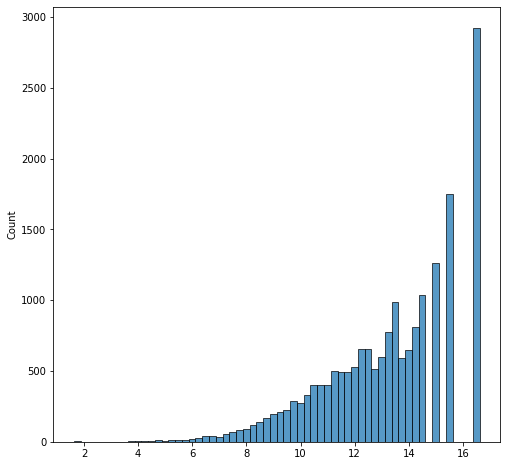

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
sns.histplot(list(vocab_idf.values()),ax=ax)

## Testing Using Attention Model

In [20]:
df["context_word_pos"] = sample_context_words(text_list=df["processed_title"],
                                              idf_thresh=9.0,
                                              pos_sample_num=3,
                                              neg_sample_num=3,
                                              cword_type="pos",
                                              filter_word_pieces=True)

Vocab_size : 18908
Vocab Size After Filtering : 13687
Failed to find context words for : 4880 docs


In [21]:
df.head(10)

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,"[defeat, pol, grow]"
1,How the US government created a fake universit...,The Department of Homeland Security created a ...,-1.0,0,the department homeland security created fake ...,how the us government created fake university ...,"[university, created, DROP_THIS]"
2,It's Time To Say It: Trump Is Handling COVID-1...,US President Donald Trump is handling the coro...,-2.0,0,president donald trump handling the coronavir...,its time to say it trump is handling covid19 l...,"[handling, dictator, DROP_THIS]"
3,Trump's draconian border lockdown has a new ta...,"For the past year, the bridges that cross from...",-2.0,0,for the past year the bridges that cross from ...,trumps draconian border lockdown has new target,"[lock, target, DROP_THIS]"
4,Supreme Court clears way for execution of fede...,"TERRE HAUTE, Ind. (AP) — The Trump administrat...",1.0,1,terre haute ind the trump administration was m...,supreme court clears way for execution of fede...,"[clears, execution, prisoner]"
5,"After testy call with Trump over border wall, ...",One Mexican official said Trump “lost his temp...,-1.0,0,one mexican official said trump lost his tempe...,after testy call with trump over border wall m...,"[mexican, shelves, DROP_THIS]"
6,"Opinion | If Congress had any pride, it would ...","This pertains to the almost 800,000 “dreamers”...",-1.0,0,this pertains the almost 800 000 dreamers our ...,opinion if congress had any pride it would set...,"[pride, DROP_THIS, DROP_THIS]"
7,Liz Cheney on Ukraine: 'Starting to Seem Like ...,Rep. Liz Cheney (R-WY) on Monday said an intel...,2.0,1,rep liz cheney monday said intelligence offici...,liz cheney on ukraine starting to seem like po...,"[starting, seem, liz]"
8,ThinkProgress Smears Dan Crenshaw on ‘Universa...,"At ThinkProgress, Josh Israel miscasts Dan Cre...",2.0,1,thinkprogress josh israel miscasts dan crensh...,thinkprogress smears dan crenshaw on universal...,"[checks, universal, background]"
9,Pompeo recalls Afghan peace envoy after Trump ...,Secretary of State Mike Pompeo said Sunday tha...,1.0,1,secretary state mike pompeo said sunday that t...,pompeo recalls afghan peace envoy after trump ...,"[camp, recalls, afghan]"


In [22]:
df["context_word_neg"] = sample_context_words(text_list=df["processed_title"],
                                              idf_thresh=9.0,
                                              neg_sample_num=3,
                                              cword_type="neg",
                                              filter_word_pieces=True)

Vocab_size : 18908
Vocab Size After Filtering : 13687
Failed to find context words for : 0 docs


In [23]:
df.head(10)

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,"[defeat, pol, grow]","[puerto, rely, martini]"
1,How the US government created a fake universit...,The Department of Homeland Security created a ...,-1.0,0,the department homeland security created fake ...,how the us government created fake university ...,"[university, created, DROP_THIS]","[est, waking, vinci]"
2,It's Time To Say It: Trump Is Handling COVID-1...,US President Donald Trump is handling the coro...,-2.0,0,president donald trump handling the coronavir...,its time to say it trump is handling covid19 l...,"[handling, dictator, DROP_THIS]","[favored, groom, horse]"
3,Trump's draconian border lockdown has a new ta...,"For the past year, the bridges that cross from...",-2.0,0,for the past year the bridges that cross from ...,trumps draconian border lockdown has new target,"[lock, target, DROP_THIS]","[gangster, showered, hammered]"
4,Supreme Court clears way for execution of fede...,"TERRE HAUTE, Ind. (AP) — The Trump administrat...",1.0,1,terre haute ind the trump administration was m...,supreme court clears way for execution of fede...,"[clears, execution, prisoner]","[capacity, financially, expensive]"
5,"After testy call with Trump over border wall, ...",One Mexican official said Trump “lost his temp...,-1.0,0,one mexican official said trump lost his tempe...,after testy call with trump over border wall m...,"[mexican, shelves, DROP_THIS]","[stokes, satirical, swear]"
6,"Opinion | If Congress had any pride, it would ...","This pertains to the almost 800,000 “dreamers”...",-1.0,0,this pertains the almost 800 000 dreamers our ...,opinion if congress had any pride it would set...,"[pride, DROP_THIS, DROP_THIS]","[replacing, implicit, fiat]"
7,Liz Cheney on Ukraine: 'Starting to Seem Like ...,Rep. Liz Cheney (R-WY) on Monday said an intel...,2.0,1,rep liz cheney monday said intelligence offici...,liz cheney on ukraine starting to seem like po...,"[starting, seem, liz]","[joke, trivial, jarrett]"
8,ThinkProgress Smears Dan Crenshaw on ‘Universa...,"At ThinkProgress, Josh Israel miscasts Dan Cre...",2.0,1,thinkprogress josh israel miscasts dan crensh...,thinkprogress smears dan crenshaw on universal...,"[checks, universal, background]","[mad, sara, vineyard]"
9,Pompeo recalls Afghan peace envoy after Trump ...,Secretary of State Mike Pompeo said Sunday tha...,1.0,1,secretary state mike pompeo said sunday that t...,pompeo recalls afghan peace envoy after trump ...,"[camp, recalls, afghan]","[janice, identity, franchise]"


In [24]:
vectors = load_bert_embeddings(df=df,
                                saved_path="/media/karthikshivaram/SABER_4TB/bert_embeddings",
                                batch_size=50,
                                layer=12,
                                context_var=100,
                                aggregation="mean")

First Ten Files : ['/media/karthikshivaram/SABER_4TB/bert_embeddings/0.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/1.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/2.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/3.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/4.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/5.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/6.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/7.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/8.npy', '/media/karthikshivaram/SABER_4TB/bert_embeddings/9.npy']
Processing Batch No : 200
Processing Batch No : 300
Processing Batch No : 400
Processing Batch No : 500
Processing Batch No : 600
Processing Batch No : 700
Processing Batch No : 800
Processing Batch No : 900
Processing Batch No : 1000
Processing Batch No : 1100
Processing Batch No : 1200
Processing Batch No : 1300
Processing Batch No : 1400
Processing Batch No : 1500
Processing Batch No : 1600
Proc

In [27]:
clean_df , doc_2_cluster_map, top100 = get_cluster_pairs_top(df,vectors)

Indices to drop : 4880
                                               title  \
0  Top general warns that 'divisiveness leads to ...   
1  How the US government created a fake universit...   

                                                text  source_partisan_score  \
0  (medianame) America's most senior general warn...                   -1.0   
1  The Department of Homeland Security created a ...                   -1.0   

   binary_ps                                     processed_text  \
0          0   medianame america most senior general warned ...   
1          0  the department homeland security created fake ...   

                                     processed_title  \
0  top general warns that divisiveness leads to d...   
1  how the us government created fake university ...   

                   context_word_pos         context_word_neg  drop_  
0               [defeat, pol, grow]  [puerto, rely, martini]  False  
1  [university, created, DROP_THIS]     [est, waking, vinci

In [28]:
# import pickle

# clean_df.to_csv("temp_df.csv",index=False)
# with open('d2c_map.pickle', 'wb') as handle:
#     pickle.dump(doc_2_cluster_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('top100.pickle', 'wb') as handle:
#     pickle.dump(top100, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
# import pickle
# import ast
# clean_df = pd.read_csv("temp_df.csv")
# clean_df["context_word_neg"] = clean_df["context_word_neg"].apply(lambda x : ast.literal_eval(x))
# doc_2_cluster_map = None
# top100 = None
# with open('d2c_map.pickle', 'rb') as handle:
#     doc_2_cluster_map = pickle.load(handle)
# with open('top100.pickle', 'rb') as handle:
#     top100 = pickle.load(handle)

In [30]:
# none_df = clean_df.loc[clean_df["context_word_pos"] == "DROP_THIS"]

In [31]:
# none_df.head(10)

In [32]:
# nan_df = clean_df[clean_df.isna().any(axis=1)]

In [33]:
# nan_df

In [34]:
clean_df.head(10)

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,"[defeat, pol, grow]","[puerto, rely, martini]",False
1,How the US government created a fake universit...,The Department of Homeland Security created a ...,-1.0,0,the department homeland security created fake ...,how the us government created fake university ...,"[university, created, DROP_THIS]","[est, waking, vinci]",False
2,It's Time To Say It: Trump Is Handling COVID-1...,US President Donald Trump is handling the coro...,-2.0,0,president donald trump handling the coronavir...,its time to say it trump is handling covid19 l...,"[handling, dictator, DROP_THIS]","[favored, groom, horse]",False
3,Trump's draconian border lockdown has a new ta...,"For the past year, the bridges that cross from...",-2.0,0,for the past year the bridges that cross from ...,trumps draconian border lockdown has new target,"[lock, target, DROP_THIS]","[gangster, showered, hammered]",False
4,Supreme Court clears way for execution of fede...,"TERRE HAUTE, Ind. (AP) — The Trump administrat...",1.0,1,terre haute ind the trump administration was m...,supreme court clears way for execution of fede...,"[clears, execution, prisoner]","[capacity, financially, expensive]",False
5,"After testy call with Trump over border wall, ...",One Mexican official said Trump “lost his temp...,-1.0,0,one mexican official said trump lost his tempe...,after testy call with trump over border wall m...,"[mexican, shelves, DROP_THIS]","[stokes, satirical, swear]",False
6,"Opinion | If Congress had any pride, it would ...","This pertains to the almost 800,000 “dreamers”...",-1.0,0,this pertains the almost 800 000 dreamers our ...,opinion if congress had any pride it would set...,"[pride, DROP_THIS, DROP_THIS]","[replacing, implicit, fiat]",False
7,Liz Cheney on Ukraine: 'Starting to Seem Like ...,Rep. Liz Cheney (R-WY) on Monday said an intel...,2.0,1,rep liz cheney monday said intelligence offici...,liz cheney on ukraine starting to seem like po...,"[starting, seem, liz]","[joke, trivial, jarrett]",False
8,ThinkProgress Smears Dan Crenshaw on ‘Universa...,"At ThinkProgress, Josh Israel miscasts Dan Cre...",2.0,1,thinkprogress josh israel miscasts dan crensh...,thinkprogress smears dan crenshaw on universal...,"[checks, universal, background]","[mad, sara, vineyard]",False
9,Pompeo recalls Afghan peace envoy after Trump ...,Secretary of State Mike Pompeo said Sunday tha...,1.0,1,secretary state mike pompeo said sunday that t...,pompeo recalls afghan peace envoy after trump ...,"[camp, recalls, afghan]","[janice, identity, franchise]",False


In [35]:
len(list(doc_2_cluster_map.keys()))

100

In [36]:
torch.cuda.empty_cache()

In [46]:
model, epoch_losses, opt, loss_func = run_all_cps(clean_df,
                                                  [top100[8]],
                                                  doc_2_cluster_map,
                                                  learning_rate=0.01,
                                                  context_pred_loss_weight=0.5,
                                                  num_epochs=1,
                                                  batch_size=1)

cluster_pair : (20, 99)
Train Shape : (865, 9)
Test Shape : (958, 9)
Original class_labels : 
1815    0
2463    1
2932    0
1953    1
4578    0
3882    1
725     1
225     0
4182    1
4605    1
Name: class_label, dtype: int64
Flipped class_labels : 
1815    1
2463    0
2932    1
1953    0
4578    1
3882    0
725     0
225     1
4182    0
4605    0
Name: class_label, dtype: int64
Train Shape : (4781, 4)
Test Shape : (5127, 4)
Train Shape : (4781, 4)
Test Shape : (5127, 4)
                                                text context_word  word_label  \
0  somebody is stocking up on the vietnam wars mo...        stock           1   
1  bloomberg out the gate  were happening russia ...         gate           1   
2  hey big spender michael bloomberg spending loa...          hey           1   
3  rnc spox 50000 new donors since democrat impea...        hours           1   
4  affirmative action restoration plan to appear ...  affirmative           1   
5  gregg jarrett an fbi that is corrup

ValueError: not enough values to unpack (expected 4, got 2)